In [594]:
import pandas 
import json 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re

from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score



In [595]:
def xuly(quotes):
    value={}
    for i in quotes:
        if(i=='quote'):continue
        value[i]=quotes[i]
    tmp= quotes['quote']
    for j in tmp:
        value[j]=tmp[j]
    return value
def xuly_data(listquotes):
    value=[]
    for i in listquotes:
        value.append(xuly(i))
    return value
        
        

In [596]:
def get_address_data(path_to_year):
    #path_to_year='./data/historical-data'
    list_path_to_year=[path_to_year+'/'+path+'/'+'coin-id-1' for path in os.listdir(path_to_year)]
    list_path=[]
    for i in list_path_to_year:
        for path in os.listdir(i):
            if path.endswith('.json'):
                list_path.append(i+'/'+path)
    return list_path
def getQuotes(path_to_year):
    data_coin_history_by_id=[]
    list_path=get_address_data(path_to_year)
    for i in list_path:
        data_tmp=json.load(open(i,'r'))
        if(len(data_tmp['quotes'])!=0):data_coin_history_by_id+=(data_tmp['quotes'])
    return data_coin_history_by_id
def xyly_ngay_gio_to_gio(object):
    tmp=object.split('T')[1]
    return tmp[0:8]
def xyly_ngay_gio_to_ngay(object):
    tmp=object.split('T')[0]
    return tmp
#xuly_data(data_coin_history_by_id)
def getData(path_to_year):
    data_coin_history_by_id=getQuotes(path_to_year)
    data_=pandas.DataFrame(xuly_data(data_coin_history_by_id))
    for i in data_.keys():
        data_=data_[data_[i]!=0]

    del data_['timeOpen']
    del data_['timeClose']
    data_['date']=''
    data_["timeHigh"] = data_["timeHigh"].apply(xyly_ngay_gio_to_gio)
    data_["timeLow"] = data_["timeLow"].apply(xyly_ngay_gio_to_gio)
    data_["date"] = data_["timestamp"].apply(xyly_ngay_gio_to_ngay)
    del data_['timestamp']
    return data_
path1='./data/historical-data'
data_train=getData(path1)
path_2022="./bitcoin-2022-historical-data/bitcoin-2022-historical-data/"
data_2022=getData(path_2022)
data=[data_train,data_2022]
data=pd.concat(data)


In [597]:
def handleDataForModel(data,id):
    data_train=data[data["date"]>='2017-01-01']

    if id==1:
        data_train=data_train[["open","close","volume","high","low"]]
        l_volume=list(data_train["volume"])
        l_volume.insert(0,0)
        l_volume.pop()
        data_train["volume_ytd"]=l_volume

        l_close=list(data_train["close"])
        l_close.insert(0,0)
        l_close.pop()
        data_train["close_ytd"]=l_close

        l_high=list(data_train["high"])
        l_high.insert(0,0)
        l_high.pop()
        data_train["high_ytd"]=l_high

        l_low=list(data_train["low"])
        l_low.insert(0,0)
        l_low.pop()
        data_train["low_ytd"]=l_low
        data_train=data_train[data_train["volume_ytd"]!=0]
        data_train=data_train[['open',"close","volume_ytd","close_ytd","high_ytd","low_ytd"]]
    if id ==2:
        data_train=data_train[["open","close"]]
    return data_train

**IMPORT LIBRARY**

In [598]:
#Scale data
from sklearn.preprocessing import MinMaxScaler    
from sklearn.preprocessing import StandardScaler

#for linear regression model
from sklearn.linear_model import LinearRegression   
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.model_selection import cross_val_score

evaluate=[]
rf_score=[]
lm_score=[]
dst_score=[]

## Random Forest ##

***Get data***

In [599]:
data_train=handleDataForModel(data,2)
data_train.shape

(2162, 2)

***Validation Set***

In [600]:
#Split data training and testing - Validation set
np.random.seed(0) #so data can have same values
df_train, df_test = train_test_split(data_train, train_size = 0.8, test_size = 0.2, random_state = 100)

***Understanding Data***

In [601]:
df_train.shape

(1729, 2)

In [602]:
df_test.shape

(433, 2)

In [603]:
df_train.describe()

,open,close
count,1729.000000,1729.000000
mean,17583.577229,17587.340307
std,16824.752167,16807.893598
min,775.177979,777.757019
25%,6442.600000,6461.010000
50%,9585.514802,9536.892686
75%,24402.187471,24402.818506
max,66953.339374,67566.830088


In [604]:
df_test.describe()

,open,close
count,433.000000,433.000000
mean,17773.289606,17785.049040
std,17016.604960,17043.568648
min,898.171997,892.687012
25%,6223.380000,6285.990000
50%,9617.821045,9690.142618
75%,23213.313242,23241.344865
max,67549.735581,66971.828097


***Train the Model***

In [605]:
temp=df_train.copy()
y_train = temp.pop('close') 
x_train = temp

In [606]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(random_state=0)    
rf.fit(x_train,y_train)

RandomForestRegressor(random_state=0)

In [607]:
t=rf.score(x_train,y_train)
rf_score.append(t)
t

0.9993936873027016

***Test data***

In [608]:
#Using model
temp=df_test.copy()
y_test = temp.pop('close')
x_test = temp
predictions = rf.predict(x_test)

***Evaluate the model***

***Cross Validation***

In [609]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

In [610]:
scores_r2_rdf = cross_val_score(rf, x_train, y_train, scoring='r2', cv=folds)
rf_score.append(scores_r2_rdf)

In [611]:
scores_mse_rdf = cross_val_score(rf, x_train, y_train, scoring='neg_mean_squared_error', cv=folds)
rf_score.append(scores_mse_rdf)

***R2 - MSE - RMSE***

In [612]:
from sklearn.metrics import r2_score 
t=r2_score(y_test, predictions)
rf_score.append(t)
t

0.9953747181647701

In [613]:
# R squared value
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
#accurancy, precision, recall - MSE - RMSE
rf_mse = mean_squared_error(y_test, predictions)
rf_rmse = np.sqrt(rf_mse)
rf_score.append(rf_mse)
rf_score.append(rf_rmse)

In [614]:
df_predict=pd.DataFrame(predictions)

C:\Users\hungn\AppData\Local\Temp\ipykernel_21544\756635654.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - predictions),ax=ax,color='b')


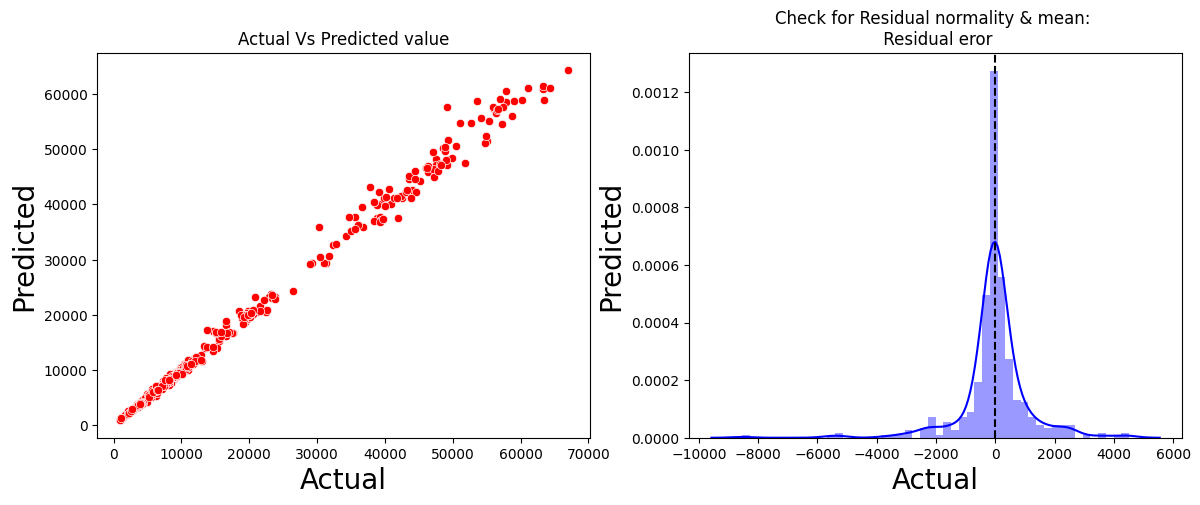

In [615]:
f = plt.figure(figsize=(14,5))

ax = f.add_subplot(121)
plt.xlabel('Actual', fontsize=20)                         
plt.ylabel('Predicted', fontsize=20)   
sns.scatterplot(x=y_test,y=predictions,ax=ax,color='r')
ax.set_title('Actual Vs Predicted value')
ax = f.add_subplot(122)
   
sns.distplot((y_test - predictions),ax=ax,color='b')

ax.axvline((y_test - predictions).mean(),color='k',linestyle='--')
plt.xlabel('Actual', fontsize=20)                         
plt.ylabel('Predicted', fontsize=20)
ax.set_title('Check for Residual normality & mean: \n Residual eror');

- Nhìn vào biểu đồ ta thấy dữ liệu thực tế với dữ liệu dự đoán gần như tương đồng nhau.
- Độ lệch dữ liệu tập trung từ -3500 đến 3500 $.

## Linear Regression ##

***Get data***

In [616]:
data_train.shape

(2162, 2)

***Train the model***

In [617]:
temp=df_train.copy()
y_train = temp.pop('close') 
x_train = temp

In [618]:
#using linear regression
lm=LinearRegression()
lm.fit(x_train,y_train)

LinearRegression()

In [619]:
t=lm.score(x_train,y_train)
lm_score.append(t)
t

0.9968506980696372

***Test data***

In [620]:
lm.coef_

array([0.99742368])

In [621]:
#Using model
temp=df_test.copy()
y_test = temp.pop('close')
x_test = temp
predictions = lm.predict(x_test)

***Evaluate the model***

***Cross Validation***

In [622]:
scores_r2_lm = cross_val_score(lm, x_train, y_train, scoring='r2', cv=folds)
lm_score.append(scores_r2_lm)

In [623]:
scores_mse_lm = cross_val_score(lm, x_train, y_train, scoring='neg_mean_squared_error', cv=folds)
lm_score.append(scores_mse_lm)

***R2 - MSE - RMSE***

In [624]:
from sklearn.metrics import r2_score 
t=r2_score(y_test, predictions)
lm_score.append(t)
t

0.9969519879778864

In [625]:
# R squared value
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
#accurancy, precision, recall - MSE - RMSE
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
lm_score.append(mse)
lm_score.append(rmse)

In [626]:
df_predict=pd.DataFrame(predictions)

C:\Users\hungn\AppData\Local\Temp\ipykernel_21544\1777820419.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - predictions),ax=ax,color='b')


Text(0.5, 1.0, 'Check for Residual normality & mean: \n Residual error')

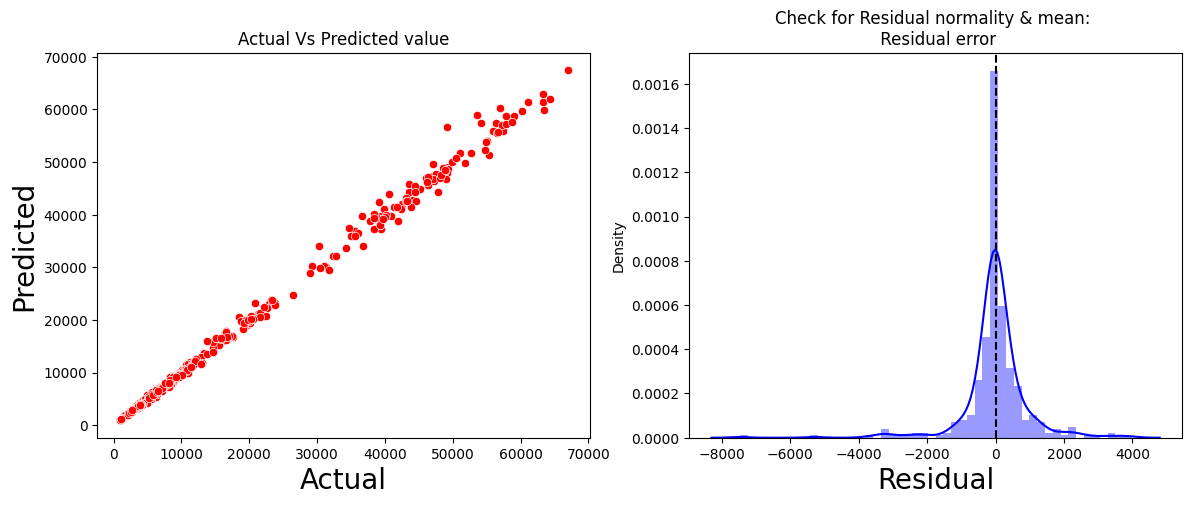

In [627]:
f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
plt.xlabel('Actual', fontsize=20)                         
plt.ylabel('Predicted', fontsize=20)   
sns.scatterplot(x=y_test,y=predictions,ax=ax,color='r')
ax.set_title('Actual Vs Predicted value')
ax = f.add_subplot(122)
   
sns.distplot((y_test - predictions),ax=ax,color='b')

ax.axvline((y_test - predictions).mean(),color='k',linestyle='--')
plt.xlabel('Residual', fontsize=20)
ax.set_title('Check for Residual normality & mean: \n Residual error')

- Nhìn vào biểu đồ ta thấy dữ liệu thực tế với dữ liệu dự đoán gần như tương đồng nhau.
- Độ lệch dữ liệu tập trung từ -2500 đến 2500 $.

## Decision Tree ##

***Train the model***

In [628]:
temp=df_train.copy()
y_train = temp.pop('close') 
x_train = temp

In [629]:
#using Decision Tree
from sklearn.tree import DecisionTreeRegressor

dtr=DecisionTreeRegressor(random_state=0)    
dtr.fit(x_train,y_train)

DecisionTreeRegressor(random_state=0)

In [630]:
t=dtr.score(x_train,y_train)
dst_score.append(t)
t

1.0

***Test data***

In [631]:
#Using model
temp=df_test.copy()
y_test = temp.pop('close')
x_test = temp
predictions = dtr.predict(x_test)

***Evaluate data***

***Cross Validation***

In [632]:
scores_r2_dst = cross_val_score(dtr, x_train, y_train, scoring='r2', cv=folds)
dst_score.append(scores_r2_dst)

In [633]:
scores_mse_dst = cross_val_score(dtr, x_train, y_train, scoring='neg_mean_squared_error', cv=folds)
dst_score.append(scores_mse_dst)

***R2-MSE-RMSE***

In [634]:
from sklearn.metrics import r2_score 
t=r2_score(y_test, predictions)
dst_score.append(t)
t

0.9941854417902709

In [635]:
# R squared value
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
#accurancy, precision, recall - MSE - RMSE
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse) 
dst_score.append(mse)
dst_score.append(rmse)

In [636]:
df_predict=pd.DataFrame(predictions)

C:\Users\hungn\AppData\Local\Temp\ipykernel_21544\458234611.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - predictions),ax=ax,color='b')


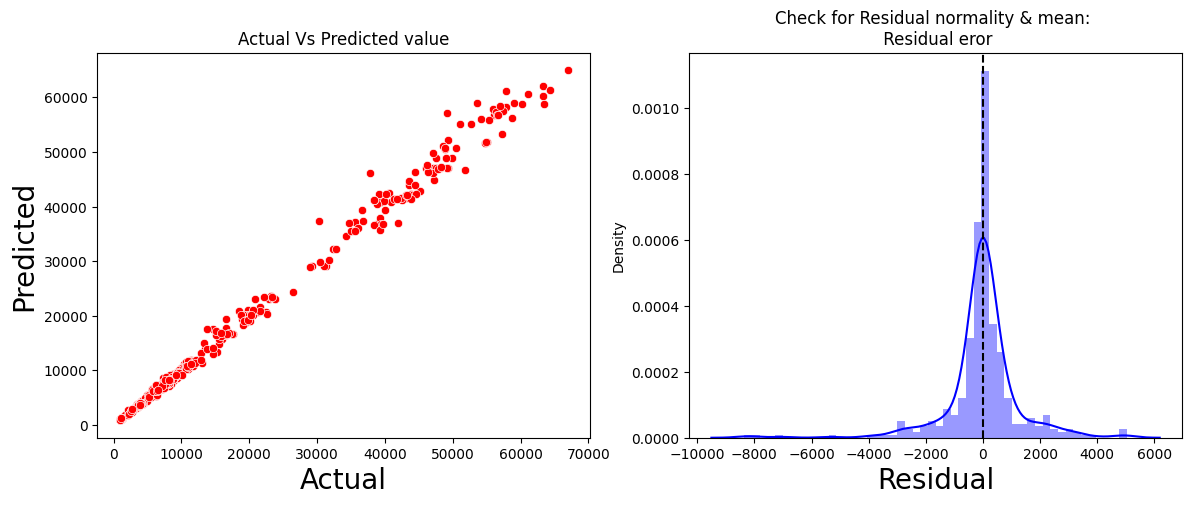

In [637]:
# Check for Linearity
f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
plt.xlabel('Actual', fontsize=20)                         
plt.ylabel('Predicted', fontsize=20)   
sns.scatterplot(x=y_test,y=predictions,ax=ax,color='r')
ax.set_title('Actual Vs Predicted value')
# Check for Residual normality & mean
ax = f.add_subplot(122)
   
sns.distplot((y_test - predictions),ax=ax,color='b')

ax.axvline((y_test - predictions).mean(),color='k',linestyle='--')
plt.xlabel('Residual', fontsize=20)                         
ax.set_title('Check for Residual normality & mean: \n Residual eror');

- Nhìn vào biểu đồ ta thấy dữ liệu thực tế với dữ liệu dự đoán gần như tương đồng nhau.
- Độ lệch dữ liệu tập trung từ -5000 đến 5000 $.

## Conclusion ##

In [638]:
rf_score

[0.9993936873027016,
 array([0.99608899, 0.99519558, 0.99442059, 0.9960797 , 0.99479725]),
 array([-1028483.40949099, -1260453.813105  , -1555047.99183284,
        -1261644.03249408, -1467165.65651512]),
 0.9953747181647701,
 1340463.8919699073,
 1157.784043753371]

In [639]:
lm_score

[0.9968506980696372,
 array([0.99729624, 0.9967408 , 0.99664889, 0.99662281, 0.99693478]),
 array([ -711012.26569422,  -855061.69036671,  -933994.85997227,
        -1086859.01792453,  -864385.78344981]),
 0.9969519879778864,
 883351.5888292486,
 939.8678571103751]

In [640]:
dst_score

[1.0,
 array([0.99506704, 0.9932551 , 0.99290935, 0.99488031, 0.99324415]),
 array([-1297225.88532585, -1769545.62243579, -1976249.81060363,
        -1647636.96473696, -1905137.6000794 ]),
 0.9941854417902709,
 1685130.897004378,
 1298.1259172377609]

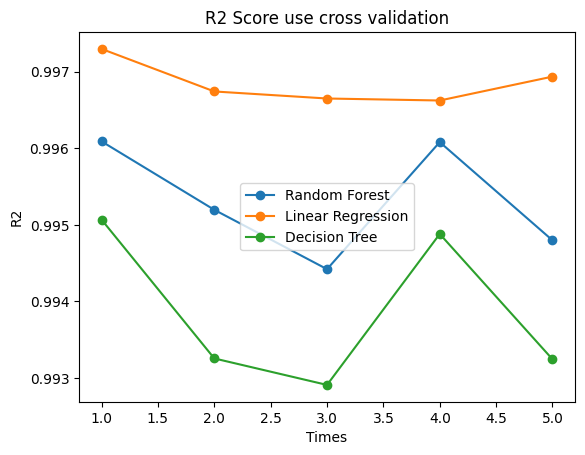

In [641]:
r2_score_all={}
r2_score_all["Random Forest"]=list(rf_score[1])
r2_score_all["Linear Regression"]=list(lm_score[1])
r2_score_all["Decision Tree"]=list(dst_score[1])

x=np.arange(int(1),int(6),int(1),dtype="int32")
y=r2_score_all["Random Forest"]
plt.title("R2 Score use cross validation")
plt.plot(x,r2_score_all["Random Forest"],label="Random Forest",marker="o")

plt.plot(x,r2_score_all["Linear Regression"],label="Linear Regression",marker="o")
plt.plot(x,r2_score_all["Decision Tree"],label="Decision Tree",marker="o")
plt.ylabel("R2")
plt.xlabel("Times")
plt.legend()
plt.show()

- Cả 3 mô hình có R2 Score cao: Linear Regression > Random Forest > Decision Tree

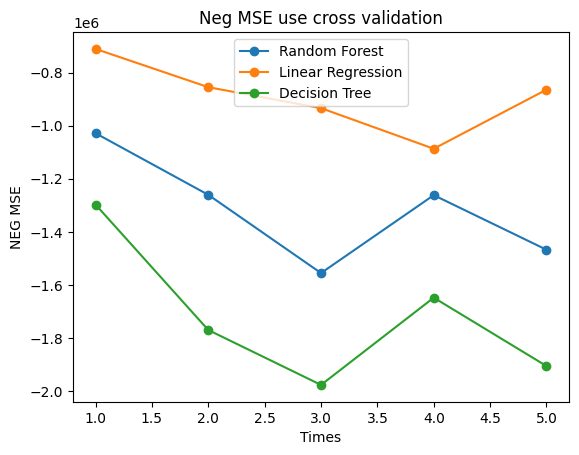

In [642]:
neg_mse_score_all={}
neg_mse_score_all["Random Forest"]=list(rf_score[2])
neg_mse_score_all["Linear Regression"]=list(lm_score[2])
neg_mse_score_all["Decision Tree"]=list(dst_score[2])

x=np.arange(int(1),int(6),int(1),dtype="int32")
y=r2_score_all["Random Forest"]
plt.title("Neg MSE use cross validation")
plt.plot(x,neg_mse_score_all["Random Forest"],label="Random Forest",marker="o")

plt.plot(x,neg_mse_score_all["Linear Regression"],label="Linear Regression",marker="o")
plt.plot(x,neg_mse_score_all["Decision Tree"],label="Decision Tree",marker="o")
plt.ylabel("NEG MSE")
plt.xlabel("Times")
plt.legend()

In [643]:
print("R2 Score Testing Data")
print("Linear Regression: ",lm_score[3])
print("Random Forest: ",rf_score[3])
print("Decision Tree: ",dst_score[3])


R2 Score Testing Data
Linear Regression:  0.9969519879778864
Random Forest:  0.9953747181647701
Decision Tree:  0.9941854417902709


In [644]:
print("MSE Testing Data")
print("Linear Regression: ",lm_score[4])
print("Random Forest: ",rf_score[4])
print("Decision Tree: ",dst_score[4])


MSE Testing Data
Linear Regression:  883351.5888292486
Random Forest:  1340463.8919699073
Decision Tree:  1685130.897004378


In [645]:
print("RMSE Testing Data")
print("Linear Regression: ",lm_score[5])
print("Random Forest: ",rf_score[5])
print("Decision Tree: ",dst_score[5])


RMSE Testing Data
Linear Regression:  939.8678571103751
Random Forest:  1157.784043753371
Decision Tree:  1298.1259172377609


- Kết luận: Nên chọn mô hình Linear Regression